## **Aplicação de XGBoost Regression**
Neste notebook será aplicado o modelo XGBoost Regression utilizando as features extraídas dos dados.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos demais modelos testados até agora. 

In [1]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import swifter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from src.outliers import detect_outliers
from src.features import add_calendar_features
from src.features import add_lagged_features
from src.evaluation import Evaluation
from src.plots import plot_metrics, plot_time_series

# configurando notebook
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# configuração de estilo
sns.set_theme(context='paper')
plt.rcParams["figure.dpi"] = 150


%load_ext autoreload
%autoreload 2

EVAL_PATH = 'data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("data/test_df.csv", parse_dates=['ds'])

## **Feature Engineering**

In [3]:
features_train_df = (
    train_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)

features_test_df = (
    test_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)

# outliers
features_train_df = detect_outliers(features_train_df)
features_test_df.loc[:, ['max_outliers', 'min_outliers']] = 0

In [4]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'max_outliers', 'min_outliers'],
      dtype='object')

In [5]:
# inserindo os lags nos dados de treino e teste

kwargs = {
    'features' : ['feriado', 'month_end'],
    'lags' : [-3, -2, -1, 1, 2, 3]
}

features_train_df = (
    features_train_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

features_test_df = (
    features_test_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

In [6]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'max_outliers', 'min_outliers',
       'feriado_lag-3', 'feriado_lag-2', 'feriado_lag-1', 'feriado_lag1',
       'feriado_lag2', 'feriado_lag3', 'month_end_lag-3', 'month_end_lag-2',
       'month_end_lag-1', 'month_end_lag1', 'month_end_lag2',
       'month_end_lag3'],
      dtype='object')

## **XGBoost Regression**

In [7]:
def xgb_regressor(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo XGBoost Regressor.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = features_test_df.query(
        "unique_id == @train.unique_id[0]"
    ).reset_index(drop=True)

    train['trend'] = train.index
    fcst_df['trend'] = fcst_df.index + train.index.max() + 1
    
    m = XGBRegressor(
        n_estimators=300, 
        random_state=1001
    )
    
    m.fit(
        X=train.iloc[:,3:], y=train.y
    )
    
    fcst_df['y_pred'] = m.predict(fcst_df.iloc[:,3:])

    return fcst_df

In [8]:
# aplicando modelo para cada série
xgb_fcst = (
    features_train_df
        .swifter
        .groupby("unique_id")
        .apply(xgb_regressor)
        .reset_index(drop=True)
)

  0%|          | 0/15 [00:00<?, ?it/s]

2025-02-20 22:53:39,667	INFO worker.py:1821 -- Started a local Ray instance.


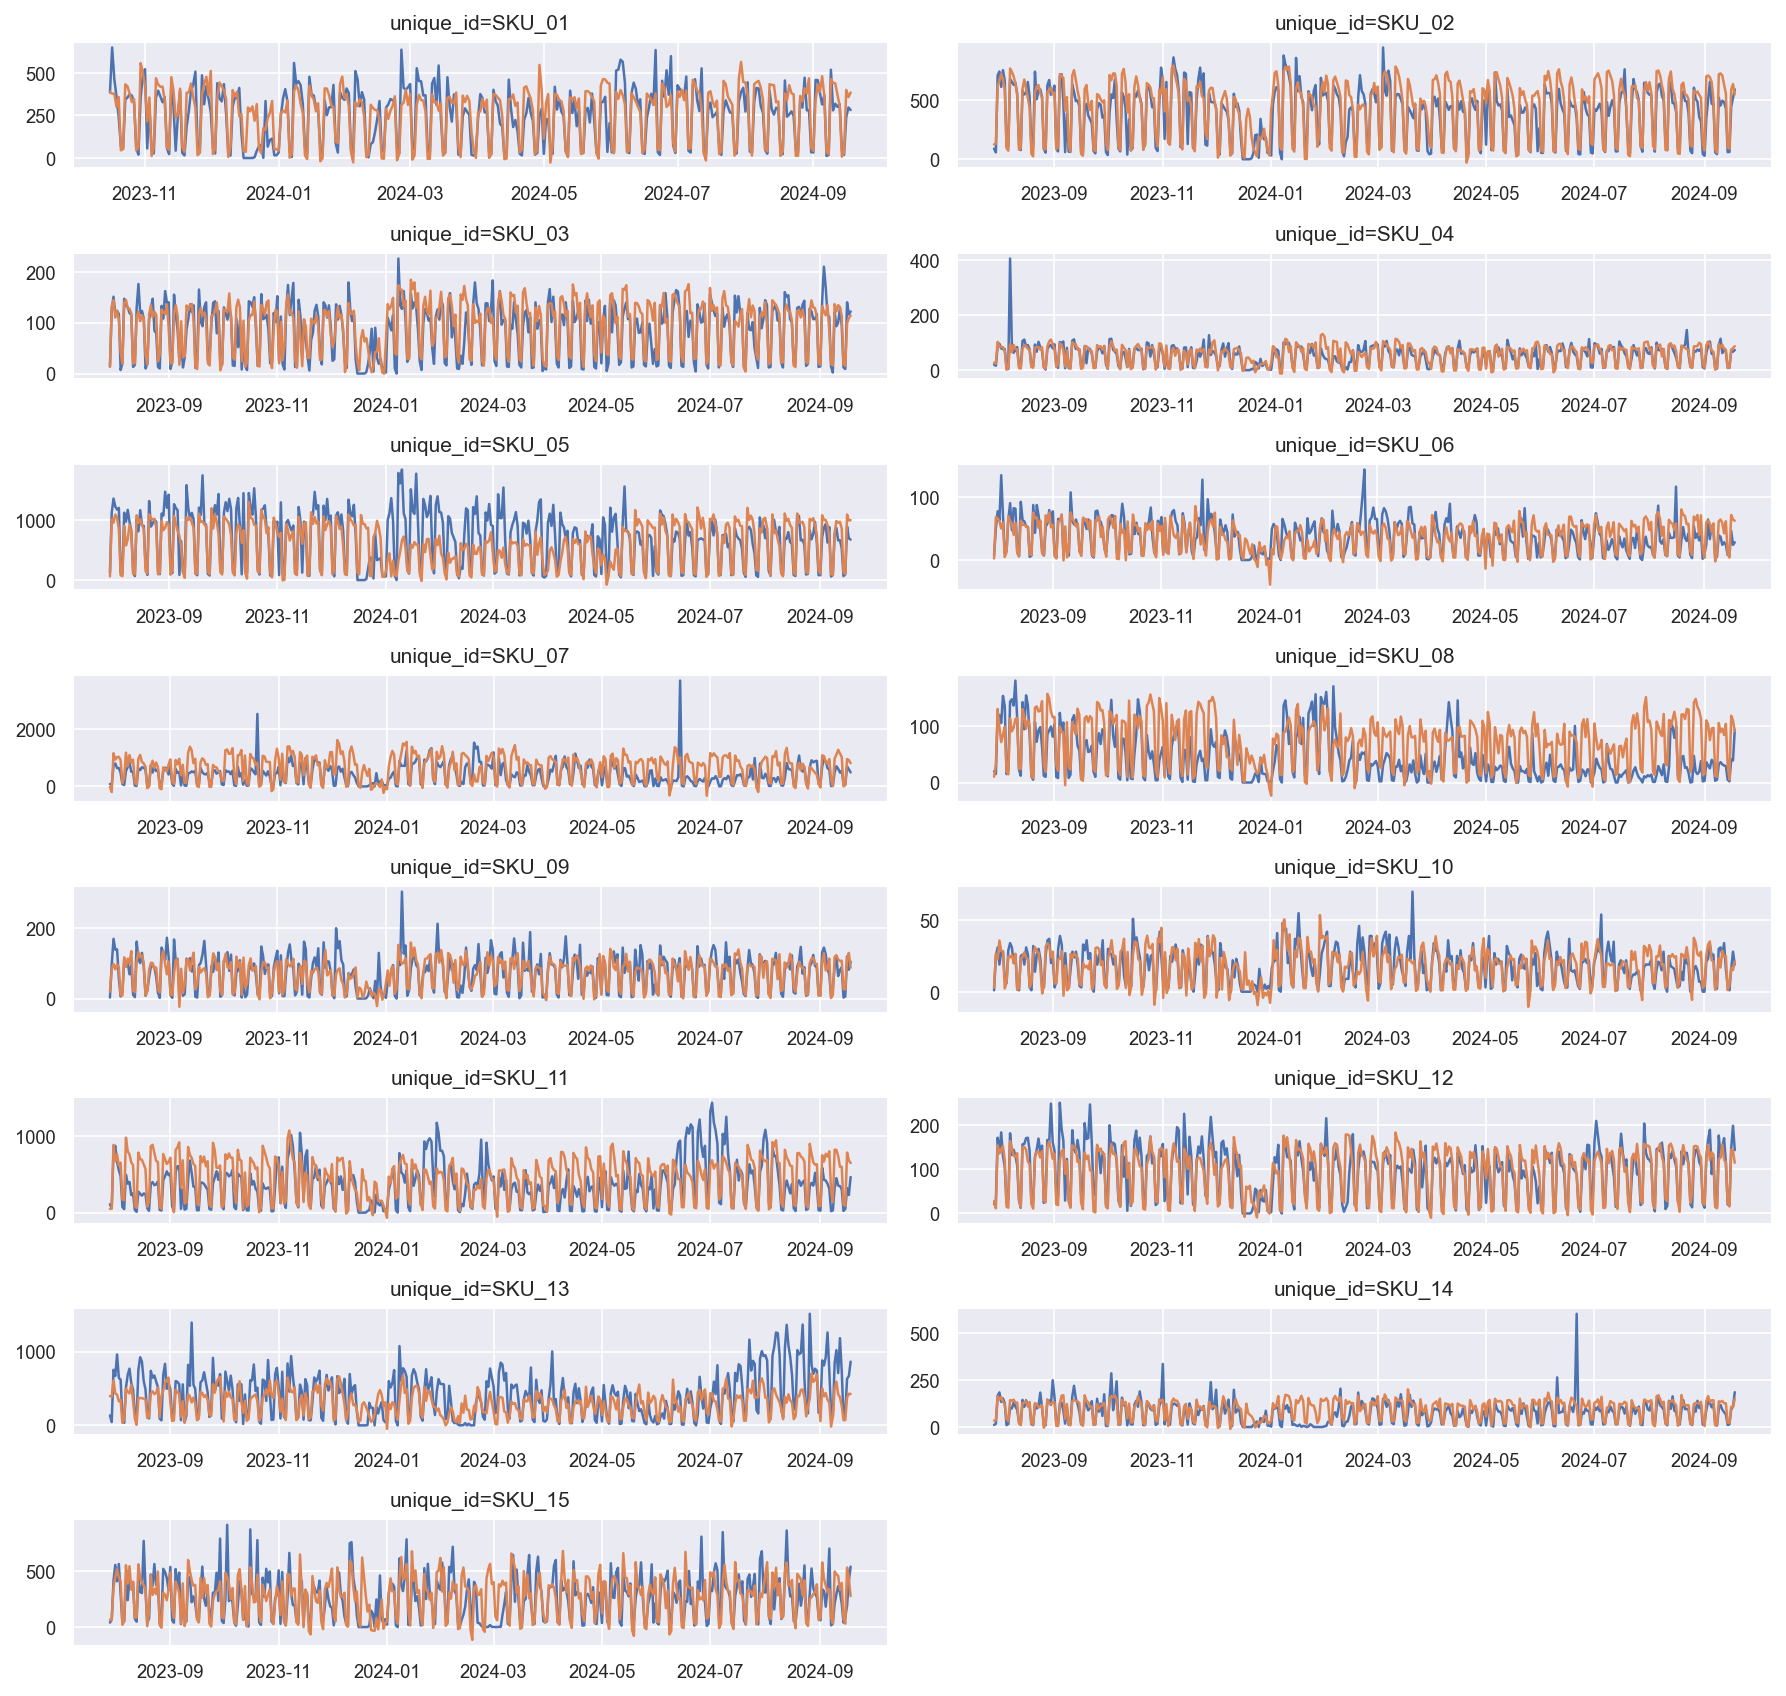

In [9]:
fig = plot_time_series(df=xgb_fcst, data_cols=['y','y_pred'])

In [10]:
rf_eval = Evaluation(xgb_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'XGBoost [+Lags]')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,75.71,10540.97,102.67,0.63
SKU_02,98.02,17729.35,133.15,0.66
SKU_03,23.41,983.08,31.35,0.65
SKU_04,15.79,676.10,26.00,0.53
SKU_05,244.86,127931.58,357.68,0.40
SKU_06,14.35,401.52,20.04,0.43
SKU_07,343.73,211804.18,460.22,-0.48
SKU_08,39.10,2414.95,49.14,-0.44
SKU_09,22.22,1020.59,31.95,0.61
SKU_10,6.70,84.15,9.17,0.47


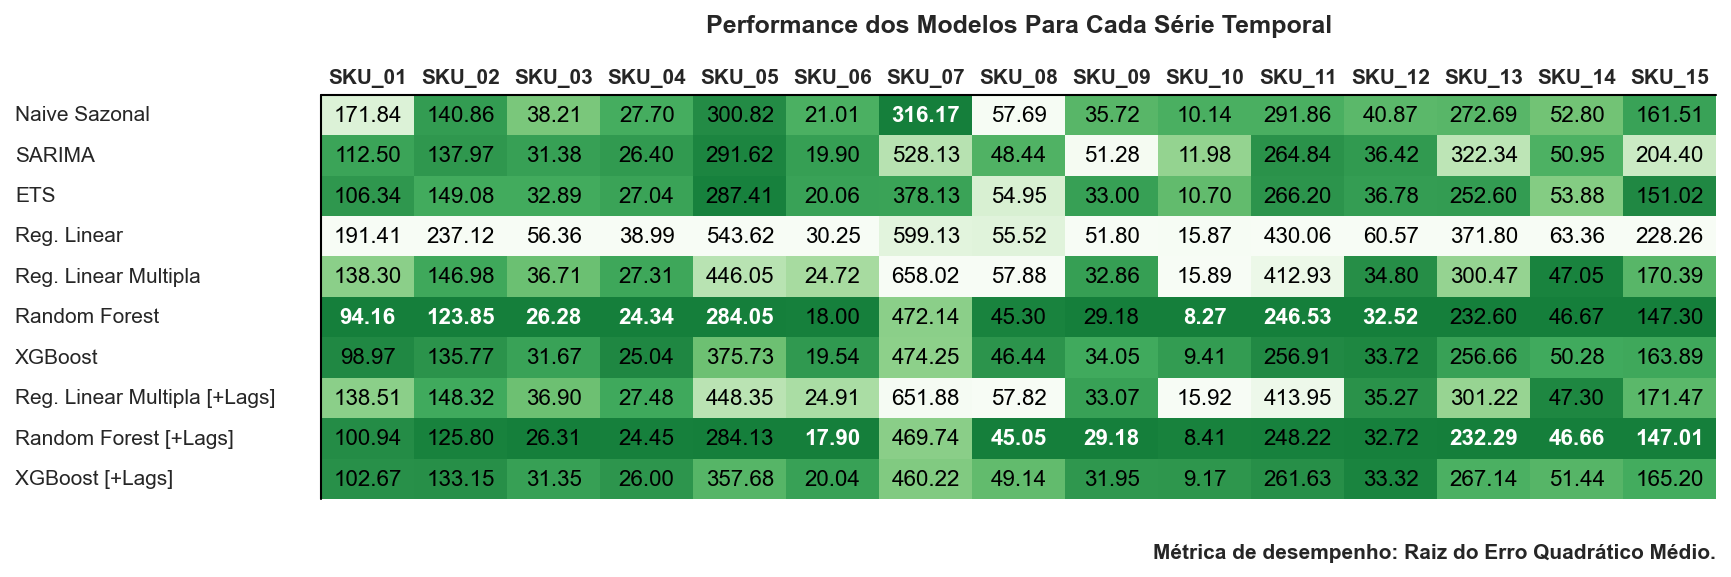

In [11]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('rmse','unique_id','model')[order]

fig = plot_metrics(metrics, figsize=(12, 3.5))